In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import mutual_info_regression as MIR

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()

## arrange data
#female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
#female_df = female_df[keep_syllables]

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v01.parquet').astype(float)
female_df = female_df[keep_syllables]

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)

In [6]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
#if 90 in cages:
#    cages.remove(90)
    
m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

# use the same number of mice per age - only age 80

# Get indices of rows where age is 80
#indices = m_data[m_data.index.get_level_values('age') == 80].index
# Choose a random index
#np.random.seed(0)
#random_index = np.random.choice(indices)
# Remove the row with the selected index
#m_data = m_data.drop(random_index)

In [7]:
#average and normalize male
avg_m_df = m_data.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_data)
avg_m_norm = mm_norm_col(avg_m_df)

#average and normalize female
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)

data=pd.concat([m_data,f_data])

In [8]:
long_data = data.copy()

In [9]:
## MI for age

In [10]:
X = long_data.to_numpy()
y = list(long_data.index.get_level_values('age'))
mi_score_long = MIR(X,y)

In [11]:
long_indx = np.argsort(mi_score_long)[::-1][0:len(keep_syllables)] # syllble index
impsyl_long= list(long_data.columns[long_indx]) #syllable id
top_mi_score_long = mi_score_long[long_indx]
imp_long = np.array(['n']*len(mi_score_long))
imp_long[np.array(long_indx)]='y'

In [12]:
print('10 most informative syllables for longtogeny: ',impsyl_long)

10 most informative syllables for longtogeny:  [12, 9, 4, 69, 49, 41, 50, 90, 97, 98, 52, 42, 79, 5, 74, 25, 62, 10, 77, 6, 11, 85, 59, 61, 53, 0, 7, 13, 70, 33, 76, 84, 55, 32, 67, 30, 44, 23, 16, 93, 27, 24, 14, 95, 71, 60, 83, 63, 73, 18, 54, 36, 68, 39, 17, 66, 64, 2]


In [13]:
## MI for identity in longtogeny

In [14]:
X = long_data.to_numpy()
y = list(long_data.index.get_level_values('sex'))
mi_score_id = MIC(X,y)

In [15]:
id_indx = np.argsort(mi_score_id)[::-1][0:len(keep_syllables)] # syllble index
impsyl_id= list(long_data.columns[id_indx]) #syllable id
top_mi_score_id = mi_score_id[id_indx]
imp_id = np.array(['n']*len(mi_score_id))
imp_id[np.array(id_indx)]='y'

In [16]:
print('10 most informative syllables for sex: ',impsyl_id)

10 most informative syllables for sex:  [69, 67, 42, 90, 11, 16, 5, 59, 23, 7, 62, 24, 50, 36, 95, 61, 39, 74, 2, 44, 68, 27, 18, 73, 9, 4, 66, 25, 71, 63, 83, 77, 17, 93, 98, 10, 70, 52, 53, 79, 0, 6, 14, 76, 64, 54, 13, 41, 84, 55, 60, 33, 12, 97, 49, 30, 32, 85]


In [17]:
syllable_classes = pd.read_csv('./v11_syllable_labels_v2.csv')
id_map = syllable_classes.set_index('Original ID')['Class']
class_sort = [id_map[k] for k in long_data.columns]

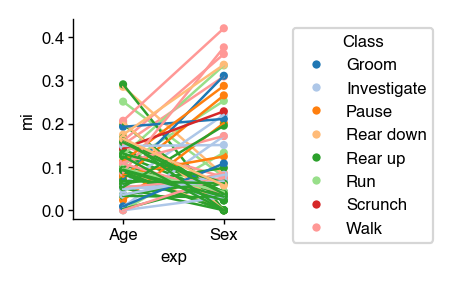

In [28]:
from sklearn.preprocessing import LabelEncoder
format_plots()
mi_df = pd.DataFrame()
mi_df['mi'] = np.concatenate((mi_score_id,mi_score_long))
mi_df['syll'] = np.concatenate((np.array(long_data.columns),np.array(long_data.columns)))
mi_df['exp'] = ['Sex']*len(long_data.columns)+['Age']*len(long_data.columns)
mi_df['rank'] = mi_df.groupby('exp')['mi'].rank()
mi_df['class'] = np.concatenate((class_sort, class_sort))

le = LabelEncoder()
le.fit(np.unique(mi_df['class'].unique()))
y = le.transform(mi_df['class'])
palette = sns.color_palette("tab20", len(np.unique(mi_df['class'])))

# Plot
format_plots()
fig, ax = plt.subplots()
fig.set_size_inches(1.3,1.3)
for i in mi_df['syll'].unique():
    sns.pointplot(data=mi_df[mi_df.syll==i], x='exp', y='mi', join=True, 
                  color=palette[y[mi_df[mi_df['syll'] == i].index[0]]],
                  order=['Age', 'Sex'], markers=['o', 's'], scale=0.5, ax=ax)  # Adjust marker size with scale

# Create legend
legend_labels = le.inverse_transform(range(len(np.unique(mi_df['class']))))
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                              markerfacecolor=color, markersize=4) for label, color in zip(legend_labels, palette)]
plt.legend(handles=legend_handles, title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside of the panel
sns.despine()
plt.show()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'MI_aging_vs_sex_ontogeny_classes.pdf')

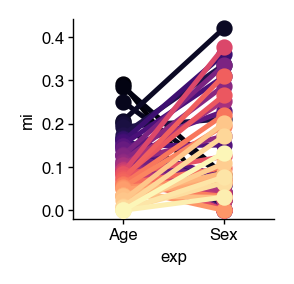

In [29]:
format_plots()
fig, ax = plt.subplots()
fig.set_size_inches(1.3,1.3)

#sns.pointplot(data=mi_df,x='exp',y='rank',hue='syll',join=True, palette='magma',hue_order=impsyl_id)
sns.pointplot(data=mi_df,x='exp',y='mi',hue='syll',join=True, palette='magma',order = ['Age','Sex'],
              hue_order=impsyl_long)

sns.despine()
ax.legend_.remove()  # Remove the legend
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'MI_aging_vs_sex_ontogeny.pdf')

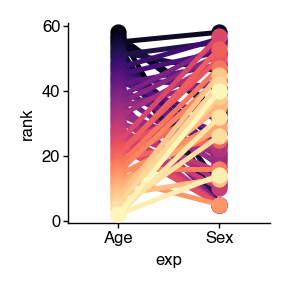

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(1.3,1.3)

#sns.pointplot(data=mi_df,x='exp',y='rank',hue='syll',join=True, palette='magma',hue_order=impsyl_id)
sns.pointplot(data=mi_df,x='exp',y='rank',hue='syll',join=True, palette='magma',order = ['Age','Sex'], hue_order=impsyl_long)
ax.legend_.remove()
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'MI_aging_vs_sex_point_RANK_ontogeny.pdf')

In [21]:
## plot differently

In [22]:
X = long_data.to_numpy()
y = list(long_data.index.get_level_values('age'))
mi_score_m = MIR(X,y)

m_rank = np.argsort(mi_score_m)[::-1]
m_scores = mi_score_m[m_rank]

In [23]:
import random
it=100
mi_shf=[]
for i in tqdm(range(it)):
    ytemp = random.shuffle(y)
    mi_temp = MIR(X,y)
    mi_shf.append(mi_temp)
    
m_sh = np.mean(mi_shf, axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]


In [24]:
m_sh = np.mean(mi_shf, axis=0)
m_scores_sh = m_sh[m_rank]

In [31]:
X = long_data.to_numpy()
y = list(long_data.index.get_level_values('sex'))
mi_score_f = MIC(X,y)

f_rank = np.argsort(mi_score_f)
f_scores = mi_score_f[m_rank] ## sorted by males

In [32]:
import random
it=100
mi_shf=[]
for i in tqdm(range(it)):
    ytemp = random.shuffle(y)
    mi_temp = MIC(X,y)
    mi_shf.append(mi_temp)
    
f_sh = np.mean(mi_shf, axis=0)
f_scores_sh = f_sh[m_rank]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.82it/s]


Text(0, 0.5, 'MI score')

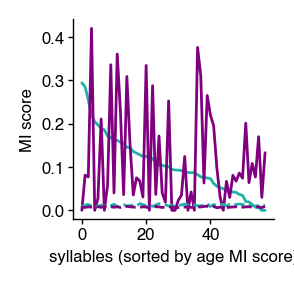

In [33]:
fig = plt.figure(figsize=(1.3, 1.3))
ax = fig.gca()
sns.lineplot(m_scores, ax=ax, color = '#20B2AA', lw=1)
sns.lineplot(f_scores, ax=ax, color = 'purple',lw=1)
sns.lineplot(m_scores_sh, ax=ax, color = '#20B2AA', lw=1, linestyle='dashed')
sns.lineplot(f_scores_sh, ax=ax, color = 'purple',lw=1,linestyle='dashed')
sns.despine()
plt.xlabel('syllables (sorted by age MI score)')
plt.ylabel('MI score')

In [ ]:
#c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig4"/ 'long_MI_aging_vs_indv_sorted_shuff_longv2.pdf')

In [ ]:
## plot example for 3 syllables with highest age MI across life for 4 mice
n=10
df_age = long_data[impsyl_long[0:n]]

In [ ]:
for i in range(n):
    fig, ax = plt.subplots()
    fig.set_size_inches(0.75,0.75) 
    sns.lineplot(data=df_age,x='age',y=impsyl_long[i],hue='mouse',marker='none',
                 palette = 'gray',
             hue_order=['M4_02','M3_02','M2_02','M1_02'],
             #hue_order=['01_01','01_02','01_03','01_04'],
             legend=False, linewidth = 0.5)
    sns.despine()
    #fig.savefig(c.dana_save_path / "fig4"/ ('example_MI_aging_longv2_'+str(impsyl_long[i])+'.pdf'))

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

for i in range(n):
    fig, ax = plt.subplots()
    fig.set_size_inches(0.75, 0.75) 
    sns.lineplot(data=df_age, x='age', y=impsyl_long[i], hue='mouse', marker='none',
                 palette='gray',
                 hue_order=['M4_02', 'M3_02', 'M2_02', 'M1_02'],
                 legend=False, linewidth=0.5, ax=ax)

    # Smooth the lines
    for line in ax.lines:
        y = line.get_ydata()
        x = line.get_xdata()
        smoothed = lowess(y, x)
        line.set_ydata(smoothed[:, 1])

    sns.despine()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
n=10

rolling_window_size = 5  # You can adjust this value according to your preference

for i in range(n):
    fig, ax = plt.subplots()
    fig.set_size_inches(0.75, 0.75) 
    sns.lineplot(data=df_age, x='age', y=impsyl_long[i], hue='mouse', marker='none',
                 palette='gray',
                 hue_order=['M4_02', 'M3_02', 'M2_02', 'M1_02'],
                 legend=False, linewidth=0.5, ax=ax)

    # Apply rolling average
    for line in ax.lines:
        y = line.get_ydata()
        rolling_y = pd.Series(y).rolling(window=rolling_window_size, min_periods=1, center=True).mean().values
        line.set_ydata(rolling_y)

    sns.despine()
    #fig.savefig(c.dana_save_path / "fig4" / ('example_MI_aging_longv2_'+str(impsyl_long[i])+'.pdf'))


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
n=5
df_age = long_data[impsyl_id[0:n]]
rolling_window_size = 5  # You can adjust this value according to your preference

for i in range(n):
    fig, ax = plt.subplots()
    fig.set_size_inches(0.75, 0.75) 
    sns.lineplot(data=df_age, x='age', y=impsyl_id[i], hue='mouse', marker='none',
                 palette='gray',
                 hue_order=['M4_02', 'M3_02', 'M2_02', 'M1_02'],
                 legend=False, linewidth=0.5, ax=ax)

    # Apply rolling average
    for line in ax.lines:
        y = line.get_ydata()
        rolling_y = pd.Series(y).rolling(window=rolling_window_size, min_periods=1, center=True).mean().values
        line.set_ydata(rolling_y)

    sns.despine()
    #fig.savefig(c.dana_save_path / "fig4" / ('example_MI_id_longv2_'+str(impsyl_long[i])+'.pdf'))

In [ ]:
for i in range(n):
    fig, ax = plt.subplots()
    fig.set_size_inches(0.75,0.75) 
    sns.lineplot(data=df_age,x='age',y=impsyl_id[i],hue='mouse',marker='none',
                 palette = 'gray',
             hue_order=['M4_02','M3_02','M2_02','M1_02'],
             #hue_order=['01_01','01_02','01_03','01_04'],
                 linewidth=0.5,
             legend=False)
    sns.despine()
    #fig.savefig(c.dana_save_path / "fig4"/ ('example_MI_id_longv2_'+str(impsyl_id[i])+'.pdf'))